<a href="https://colab.research.google.com/github/Khayarovde/data-science.-Ri-230946/blob/main/Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

Описание dataset:
Контекст задачи
Записи о продажах с 2011 по 2014 годы, включающие 3 основные категории товаров и 17 подкатегорий, представлены с детализацией по регионам и сегментам.

Описание ключевых признаков:
State (Штат): Штат, в котором проживает клиент (внутри страны).

City (Город): Город проживания клиента.

Region (Регион): Географический регион (например, Запад, Юг и т.д.).

Segment (Сегмент): Тип клиента/рынка: Consumer, Corporate, Home Office и др.

Ship Mode (Способ доставки): Метод доставки заказа до клиента.

Category (Категория): Основная категория товара (например, Мебель, Техника).

Sub-Category (Подкатегория): Более точная классификация товаров.

Product Name (Наименование товара): Название конкретного продукта.

Discount (Скидка): Скидка, применённая к товару.

Sales (Продажи): Общая сумма продаж по заказу.

Profit (Прибыль): Полученная прибыль по заказу.

Quantity (Количество): Количество единиц товара в заказе.

Feedback (Отзыв): Признак — оставил ли клиент отзыв (True/False).

In [29]:
print("Скачиваем датасет через kagglehub...")
path = kagglehub.dataset_download("braniac2000/retail-dataset")
print(f"Путь к скачанной папке: {path}")

xlsx_path = None
for root, dirs, files in os.walk(path):
    for f in files:
        if f.endswith(".xlsx"):
            xlsx_path = os.path.join(root, f)
            break
    if xlsx_path:
        break

if xlsx_path is None:
    raise ValueError("Файл .xlsx не найден!")

print(f"Используем Excel-файл: {xlsx_path}")

df = pd.read_excel(xlsx_path, sheet_name='Order Data')
print(f"Исходный размер данных: {df.shape}")


Скачиваем датасет через kagglehub...
Путь к скачанной папке: C:\Users\user\.cache\kagglehub\datasets\braniac2000\retail-dataset\versions\1
Используем Excel-файл: C:\Users\user\.cache\kagglehub\datasets\braniac2000\retail-dataset\versions\1\Capstone1C_EuroMart Stores-1.xlsx
Исходный размер данных: (8047, 17)


Скачивание файла dataset, который проверяет установился ли файл, либо же нет.

In [30]:
# Отфильтровать строки без пропусков (NaN)
df_no_nan = df.dropna()

# Получить описательную статистику по отфильтрованным данным
desc_no_nan = df_no_nan.describe(include='all')

# Показать результат
num_non_null_rows = df.dropna().shape[0]

print(f"Количество строк без пропусков: {num_non_null_rows}")


Количество строк без пропусков: 8047


Очистка не работает, т.к. решил убрать по причине того, что не null строк.

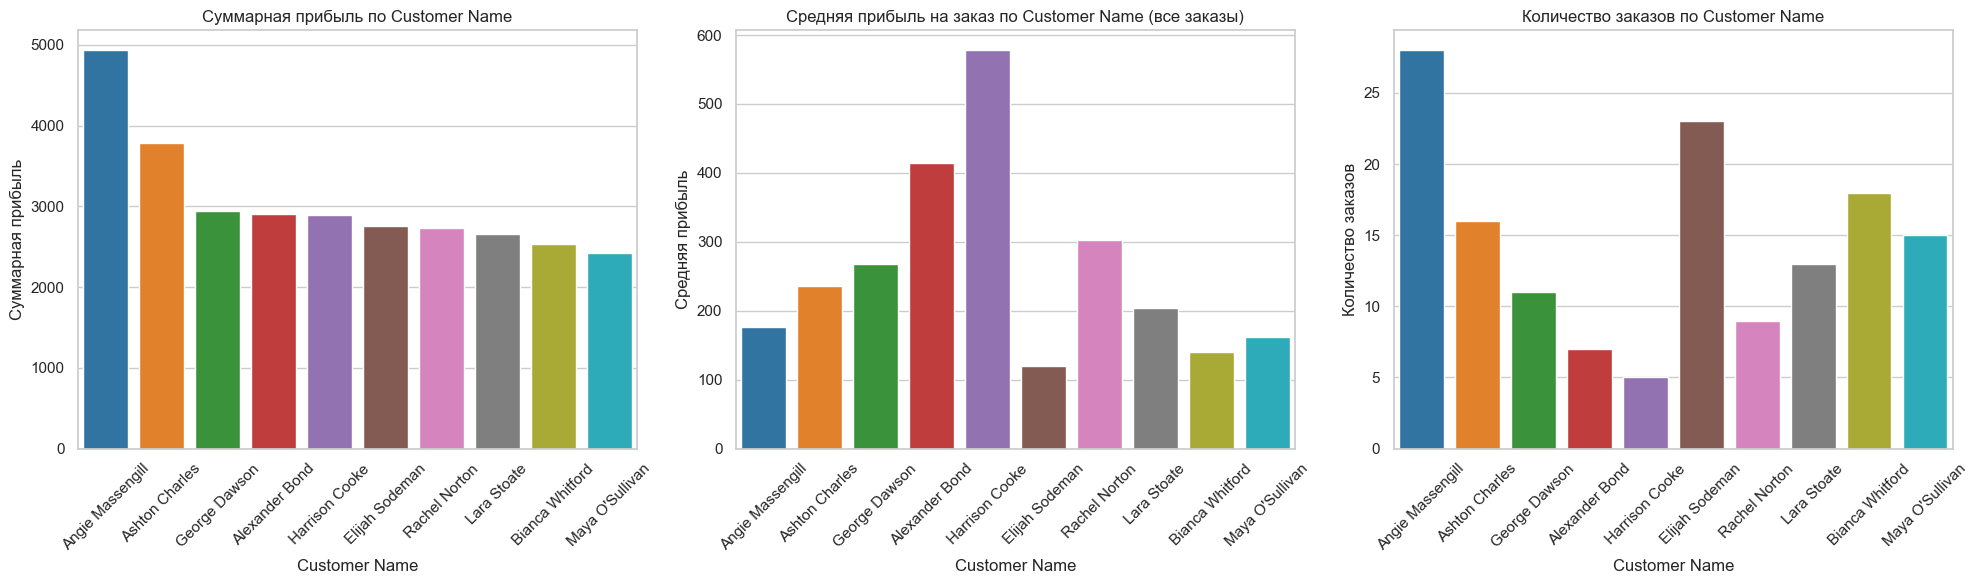


📊 Распределение прибыли по категориям внутри топ-10 Customer Name


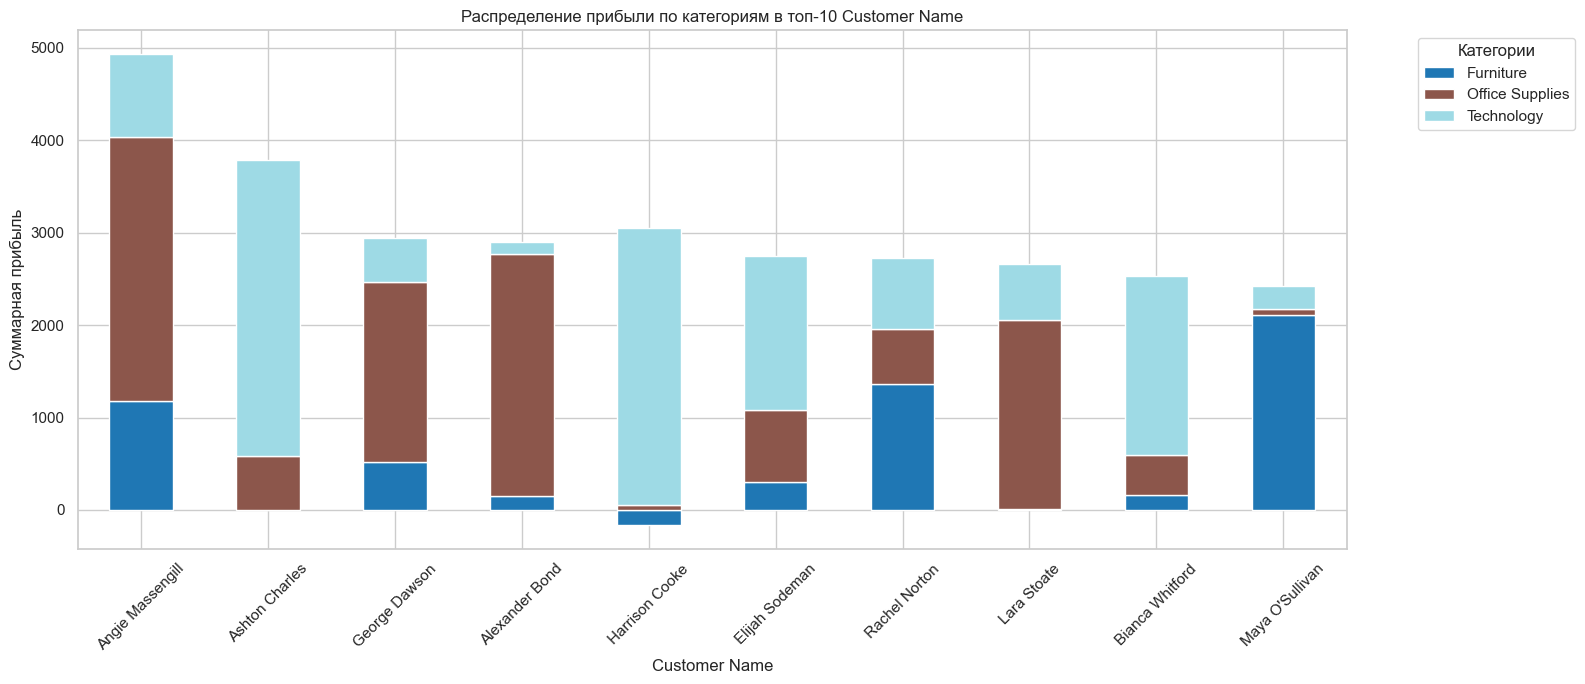


💡 Вывод по 'Customer Name':
- Максимальная суммарная прибыль у 'Angie Massengill' — 4 932
- Минимальная суммарная прибыль у 'Maya O'Sullivan' — 2 418
- Средняя прибыль на заказ (все заказы) варьируется от 119.65 до 577.80
- Средняя прибыль на заказ (только прибыльные) варьируется от 125.36 до 1023.33
- Количество заказов в топ-10 'Customer Name' варьируется от 5 до 28
- Процент убыточных заказов в топ-10 'Customer Name':
  • Angie Massengill: 3.57%
  • Ashton Charles: 12.50%
  • George Dawson: 18.18%
  • Alexander Bond: 0.00%
  • Harrison Cooke: 40.00%
  • Elijah Sodeman: 4.35%
  • Rachel Norton: 11.11%
  • Lara Stoate: 7.69%
  • Bianca Whitford: 5.56%
  • Maya O'Sullivan: 6.67%


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

def analyze_profit_by_category(df, col, top_n=10):
    # Считаем суммарную прибыль по всем уникальным значениям (включая отрицательные)
    total_profit = df.groupby(col)['Profit'].sum()

    # Отбираем топ-N значений с наибольшей суммарной прибылью (по убыванию)
    top_vals = total_profit.sort_values(ascending=False).head(top_n).index.tolist()

    # Фильтруем исходный датафрейм по топ-N
    df_top = df[df[col].isin(top_vals)].copy()

    # Считаем метрики по всем заказам (включая отрицательные)
    profit_sum = df_top.groupby(col)['Profit'].sum().reindex(top_vals)
    avg_profit_all = df_top.groupby(col)['Profit'].mean().reindex(top_vals)

    # Средняя прибыль только по прибыльным заказам (для информации)
    avg_profit_positive = df_top[df_top['Profit'] > 0].groupby(col)['Profit'].mean().reindex(top_vals)

    order_count = df_top.groupby(col).size().reindex(top_vals)

    # Процент убыточных заказов
    loss_counts = df_top[df_top['Profit'] < 0].groupby(col).size().reindex(top_vals).fillna(0)
    loss_percent = (loss_counts / order_count * 100).fillna(0)

    # Цвета для топовых значений
    palette = sns.color_palette("tab10", n_colors=len(top_vals))
    color_dict = dict(zip(top_vals, palette))

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Суммарная прибыль
    sns.barplot(x=profit_sum.index, y=profit_sum.values, palette=[color_dict[x] for x in profit_sum.index], ax=axes[0])
    axes[0].set_title(f"Суммарная прибыль по {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Суммарная прибыль")
    axes[0].tick_params(axis='x', rotation=45)

    # Средняя прибыль (все заказы)
    sns.barplot(x=avg_profit_all.index, y=avg_profit_all.values, palette=[color_dict[x] for x in avg_profit_all.index], ax=axes[1])
    axes[1].set_title(f"Средняя прибыль на заказ по {col} (все заказы)")
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("Средняя прибыль")
    axes[1].tick_params(axis='x', rotation=45)

    # Количество заказов
    sns.barplot(x=order_count.index, y=order_count.values, palette=[color_dict[x] for x in order_count.index], ax=axes[2])
    axes[2].set_title(f"Количество заказов по {col}")
    axes[2].set_xlabel(col)
    axes[2].set_ylabel("Количество заказов")
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Распределение прибыли по категориям
    print(f"\n📊 Распределение прибыли по категориям внутри топ-{top_n} {col}")
    profit_by_cat = df_top.groupby([col, 'Category'])['Profit'].sum().unstack(fill_value=0).reindex(top_vals)

    profit_by_cat.plot(kind='bar', stacked=True, figsize=(16, 7), colormap='tab20')
    plt.title(f"Распределение прибыли по категориям в топ-{top_n} {col}")
    plt.xlabel(col)
    plt.ylabel("Суммарная прибыль")
    plt.xticks(rotation=45)
    plt.legend(title='Категории', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    best_sum_profit = profit_sum.idxmax()
    worst_sum_profit = profit_sum.idxmin()

    def fmt_int(n):
        return f"{int(n):,}".replace(",", " ")

    def fmt_float(n):
        return f"{n:.2f}"

    print(f"\n💡 Вывод по '{col}':")
    print(f"- Максимальная суммарная прибыль у '{best_sum_profit}' — {fmt_int(profit_sum.max())}")
    print(f"- Минимальная суммарная прибыль у '{worst_sum_profit}' — {fmt_int(profit_sum.min())}")
    print(f"- Средняя прибыль на заказ (все заказы) варьируется от {fmt_float(avg_profit_all.min())} до {fmt_float(avg_profit_all.max())}")
    print(f"- Средняя прибыль на заказ (только прибыльные) варьируется от {fmt_float(avg_profit_positive.min())} до {fmt_float(avg_profit_positive.max())}")
    print(f"- Количество заказов в топ-{top_n} '{col}' варьируется от {fmt_int(order_count.min())} до {fmt_int(order_count.max())}")
    print(f"- Процент убыточных заказов в топ-{top_n} '{col}':")
    for val in top_vals:
        print(f"  • {val}: {fmt_float(loss_percent[val])}%")


analyze_profit_by_category(df, 'Customer Name')



Максимальная прибыль концентрируется у небольшого числа клиентов с большим числом заказов и высокой средней прибылью. При этом у некоторых клиентов высокий процент убыточных заказов, что может на акции или скидки, либо на процент возвратов.

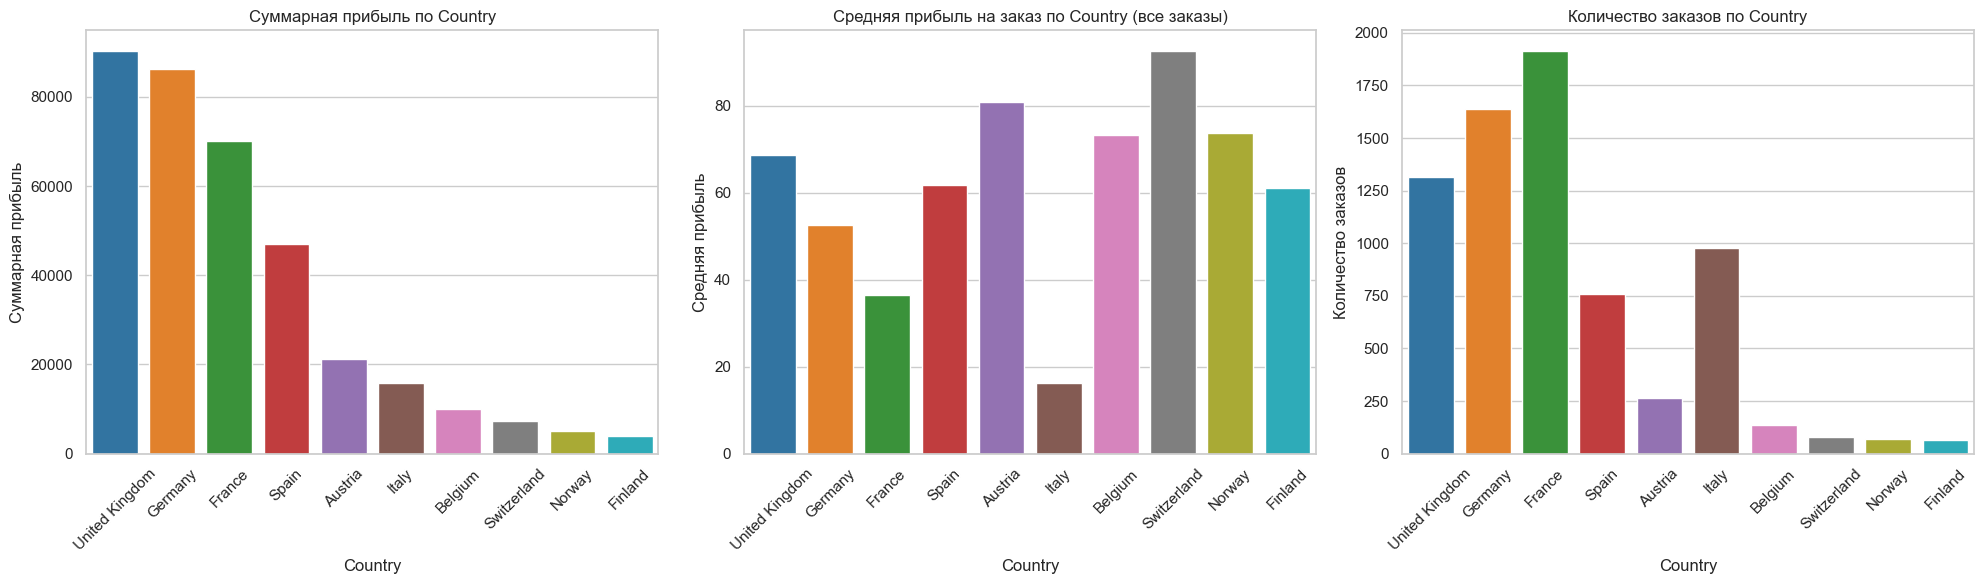


📊 Распределение прибыли по категориям внутри топ-10 Country


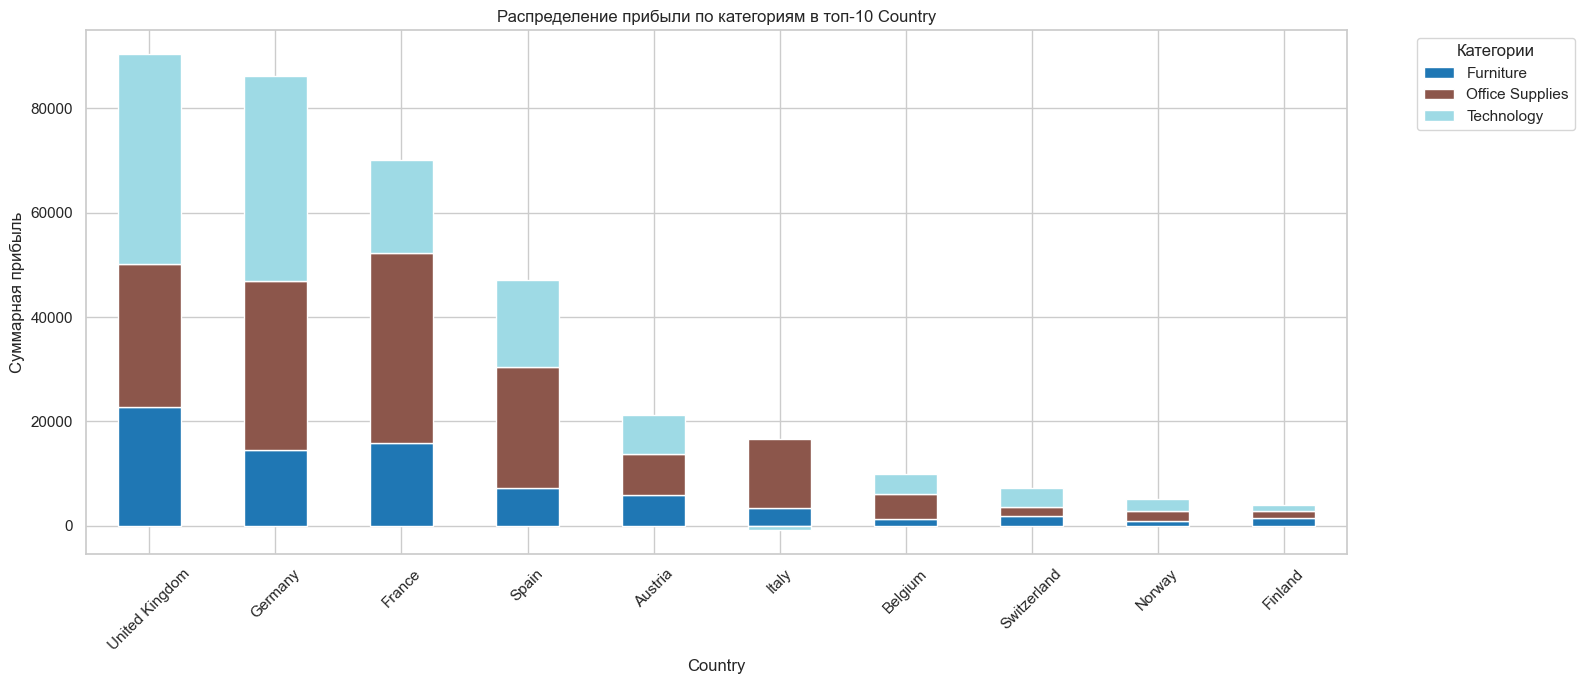


💡 Вывод по 'Country':
- Максимальная суммарная прибыль у 'United Kingdom' — 90 382
- Минимальная суммарная прибыль у 'Finland' — 3 908
- Средняя прибыль на заказ (все заказы) варьируется от 16.14 до 92.74
- Средняя прибыль на заказ (только прибыльные) варьируется от 62.03 до 95.18
- Количество заказов в топ-10 'Country' варьируется от 64 до 1 916
- Процент убыточных заказов в топ-10 'Country':
  • United Kingdom: 13.09%
  • Germany: 10.43%
  • France: 15.66%
  • Spain: 9.99%
  • Austria: 0.00%
  • Italy: 23.70%
  • Belgium: 0.00%
  • Switzerland: 0.00%
  • Norway: 0.00%
  • Finland: 0.00%


In [32]:
analyze_profit_by_category(df, 'Country')

Как видно, основная прибыль поступает из крупных городов с развитой экономикой. При этом спрос разделён не однородно, так многие страны имели низкую доходность, но скорее вызвано тем, что часть товаров не было, а с другой стороны в более развитых странах наблюдается больших процент убыточных заказов

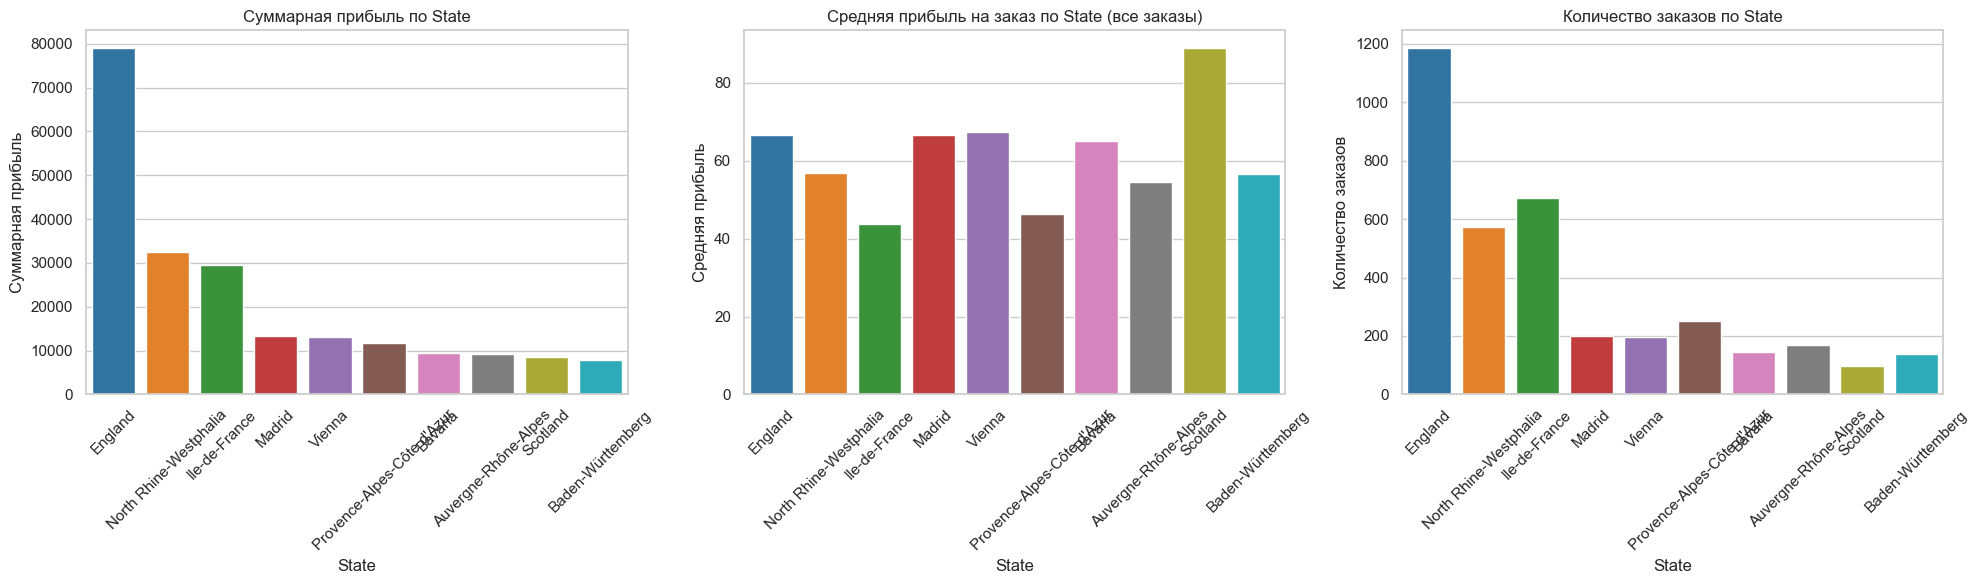


📊 Распределение прибыли по категориям внутри топ-10 State


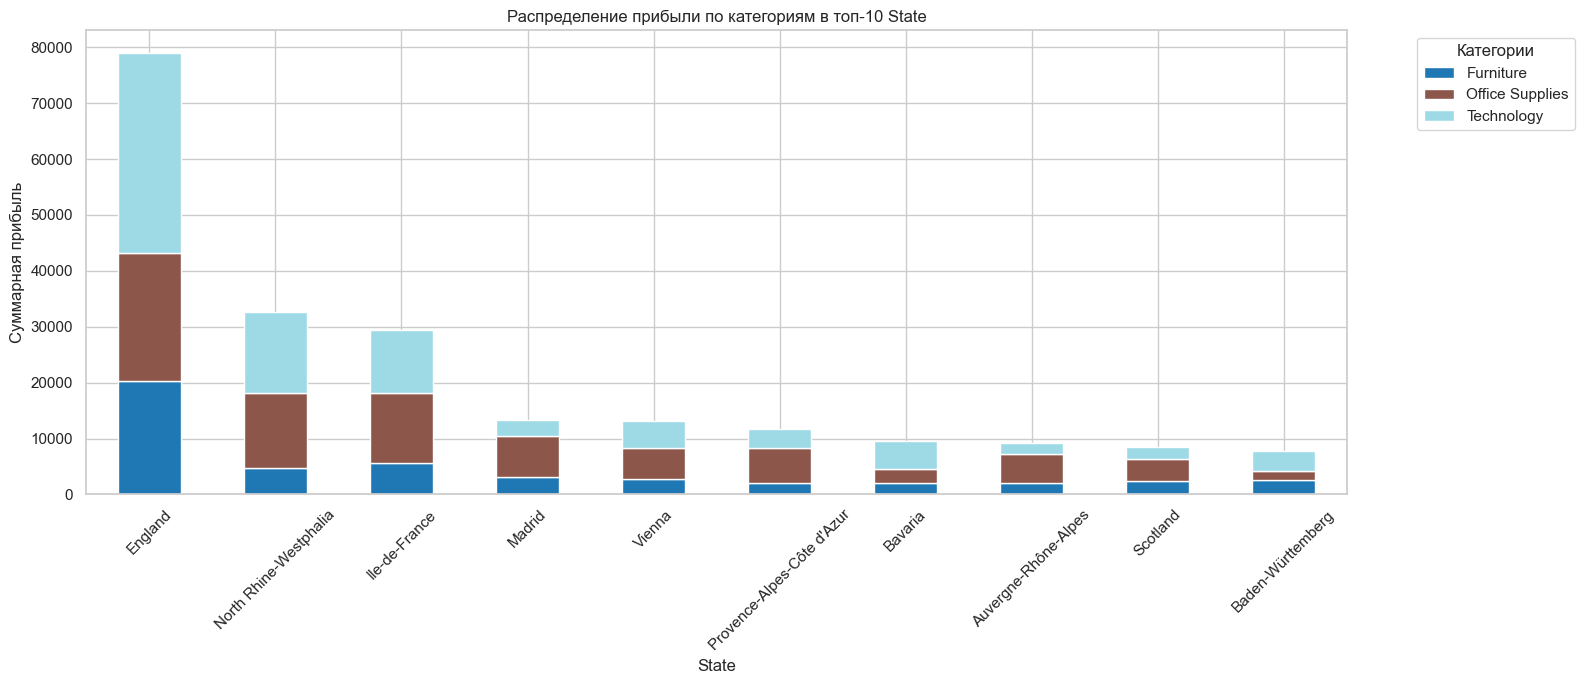


💡 Вывод по 'State':
- Максимальная суммарная прибыль у 'England' — 79 069
- Минимальная суммарная прибыль у 'Baden-Württemberg' — 7 762
- Средняя прибыль на заказ (все заказы) варьируется от 43.77 до 89.05
- Средняя прибыль на заказ (только прибыльные) варьируется от 62.02 до 96.03
- Количество заказов в топ-10 'State' варьируется от 96 до 1 187
- Процент убыточных заказов в топ-10 'State':
  • England: 14.15%
  • North Rhine-Westphalia: 6.29%
  • Ile-de-France: 11.14%
  • Madrid: 8.54%
  • Vienna: 0.00%
  • Provence-Alpes-Côte d'Azur: 13.60%
  • Bavaria: 6.85%
  • Auvergne-Rhône-Alpes: 14.71%
  • Scotland: 3.12%
  • Baden-Württemberg: 7.30%


In [33]:
analyze_profit_by_category(df, 'State')

Максимальная прибыль и количество заказов сосредоточены в экономически развитых штатах (например, England). Высокий процент убыточных заказов в некоторых штатах указывает на снижение маржинальности, возможно из-за скидок или возвратов.

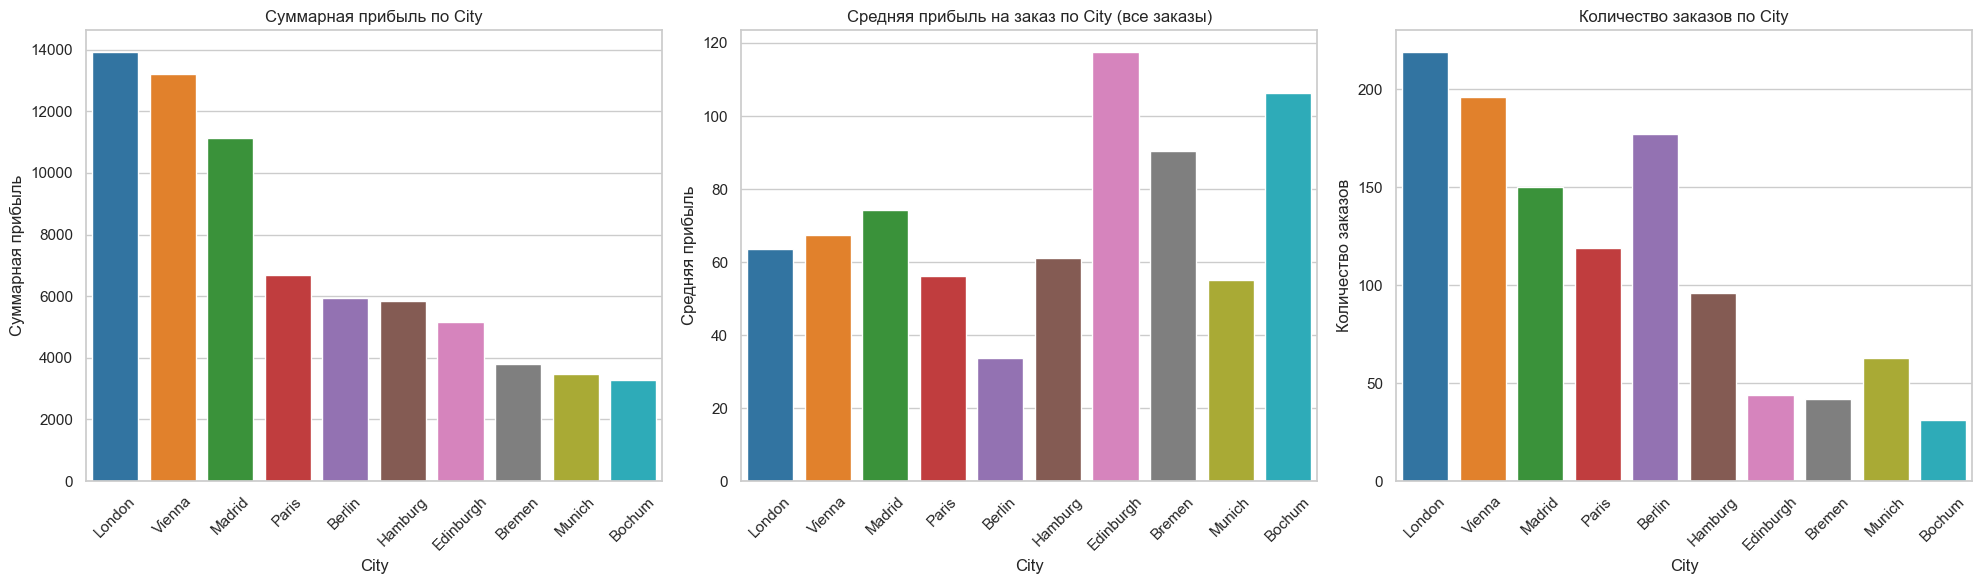


📊 Распределение прибыли по категориям внутри топ-10 City


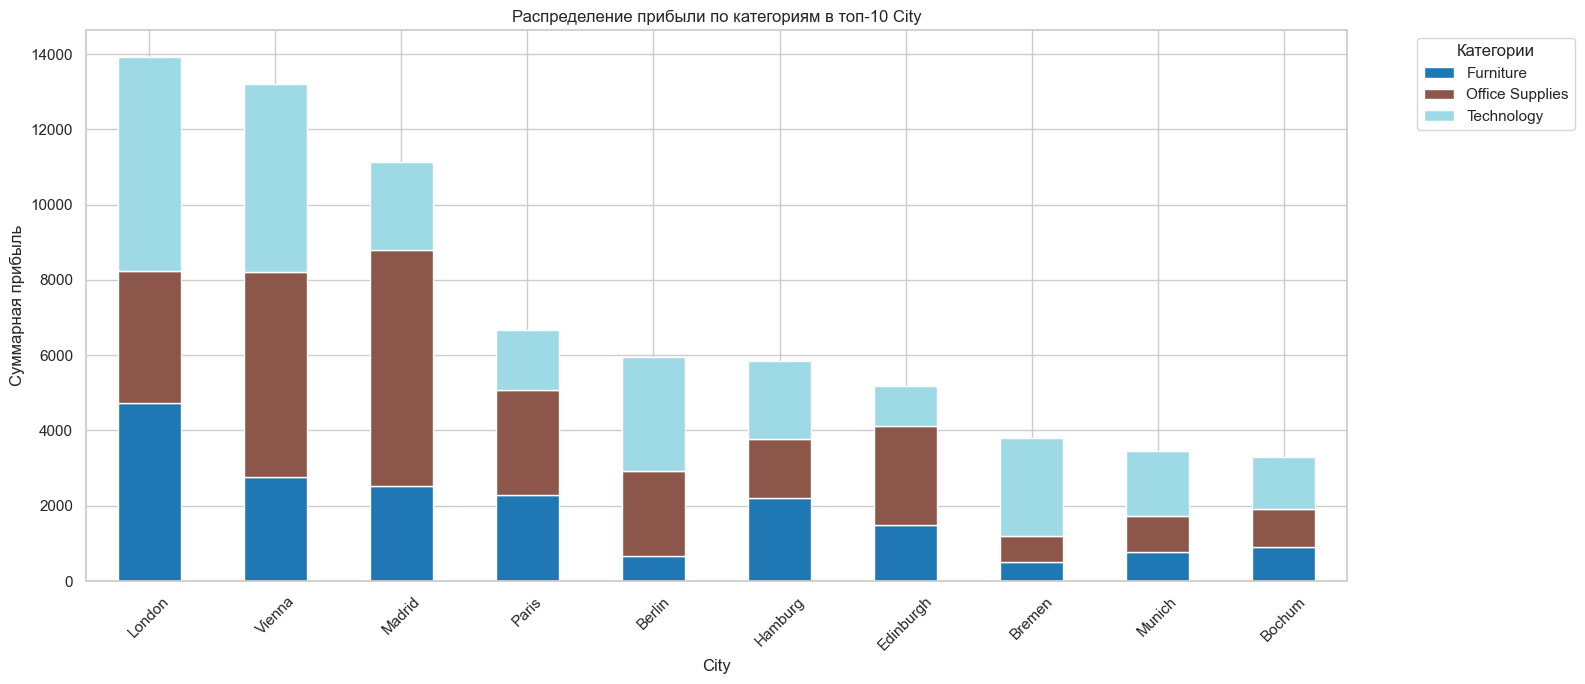


💡 Вывод по 'City':
- Максимальная суммарная прибыль у 'London' — 13 931
- Минимальная суммарная прибыль у 'Bochum' — 3 295
- Средняя прибыль на заказ (все заказы) варьируется от 33.57 до 117.57
- Средняя прибыль на заказ (только прибыльные) варьируется от 59.06 до 131.35
- Количество заказов в топ-10 'City' варьируется от 31 до 219
- Процент убыточных заказов в топ-10 'City':
  • London: 17.35%
  • Vienna: 0.00%
  • Madrid: 8.67%
  • Paris: 11.76%
  • Berlin: 22.03%
  • Hamburg: 1.04%
  • Edinburgh: 4.55%
  • Bremen: 4.76%
  • Munich: 4.76%
  • Bochum: 6.45%


In [34]:
analyze_profit_by_category(df, 'City')

Как видно, основные заказы поступают из городов с высокой экономической активностью. При этом спрос по категориям товаров варьируется: в некоторых городах преобладает покупка технологичных товаров, тогда как в других спрос на другие товары.


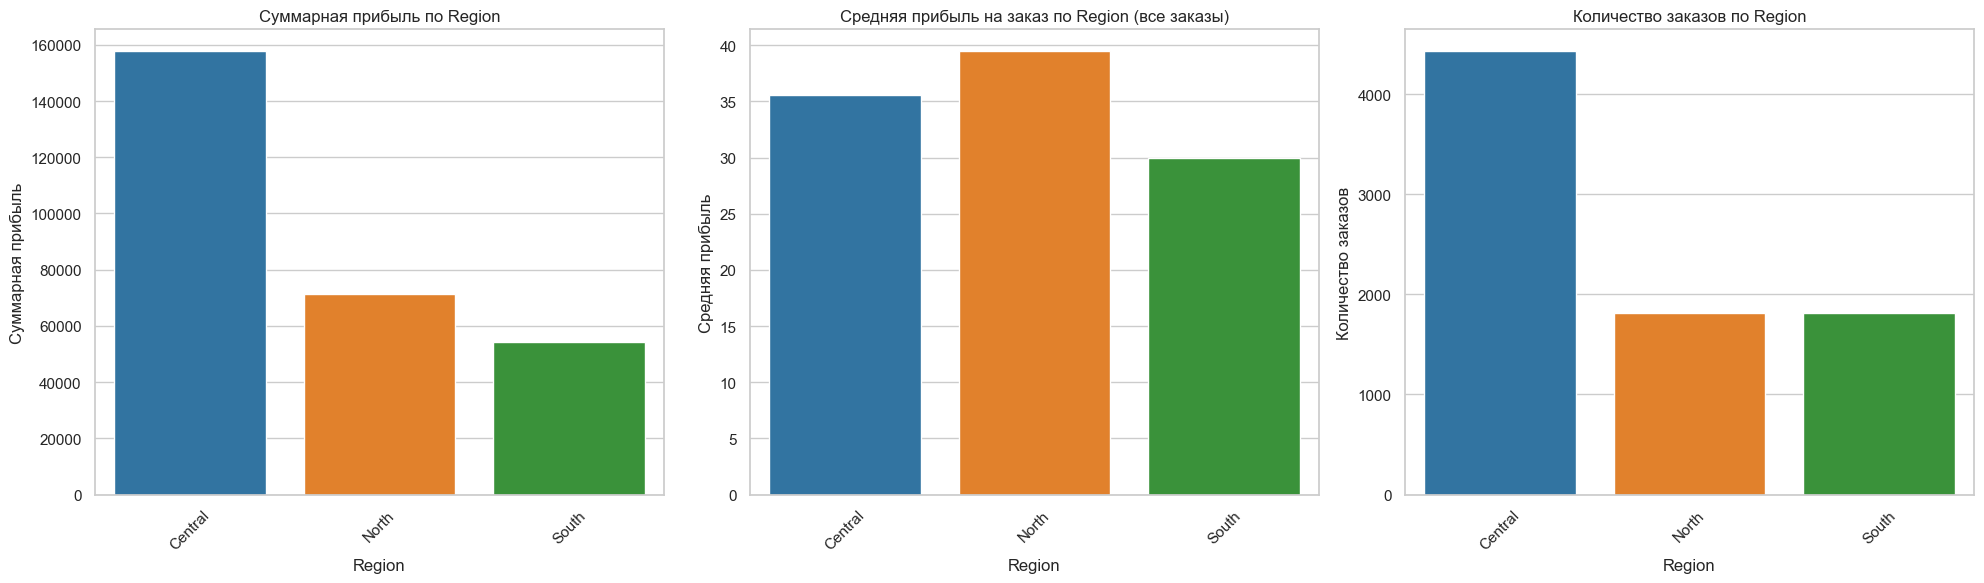


📊 Распределение прибыли по категориям внутри топ-10 Region


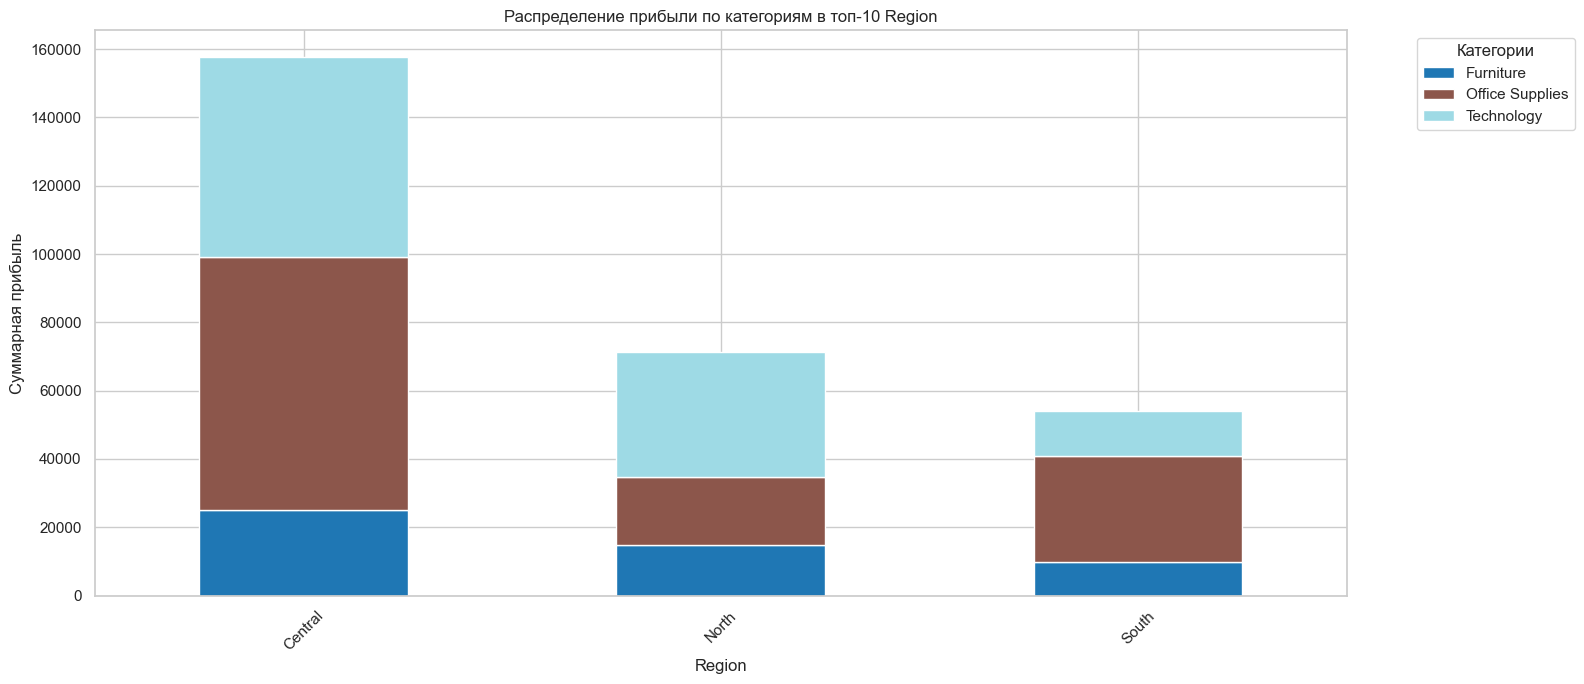


💡 Вывод по 'Region':
- Максимальная суммарная прибыль у 'Central' — 157 636
- Минимальная суммарная прибыль у 'South' — 54 165
- Средняя прибыль на заказ (все заказы) варьируется от 29.93 до 39.45
- Средняя прибыль на заказ (только прибыльные) варьируется от 68.35 до 87.67
- Количество заказов в топ-10 'Region' варьируется от 1 810 до 4 426
- Процент убыточных заказов в топ-10 'Region':
  • Central: 18.84%
  • North: 28.93%
  • South: 20.77%


In [35]:
analyze_profit_by_category(df, 'Region')

Центральные районы приносят максимальную прибыль при умеренном уровне убыточных заказов. Южные показывает минимальную прибыль с похожим уровнем убытков. В Северный высокий процент убыточных заказов снижает эффективность продаж. Разные регионы требуют разных стратегий из-за отличий в прибыльности и рисках, а также то, что центральный регион чаще всего является регионом столицей, из-за чего количество клиентов больше.

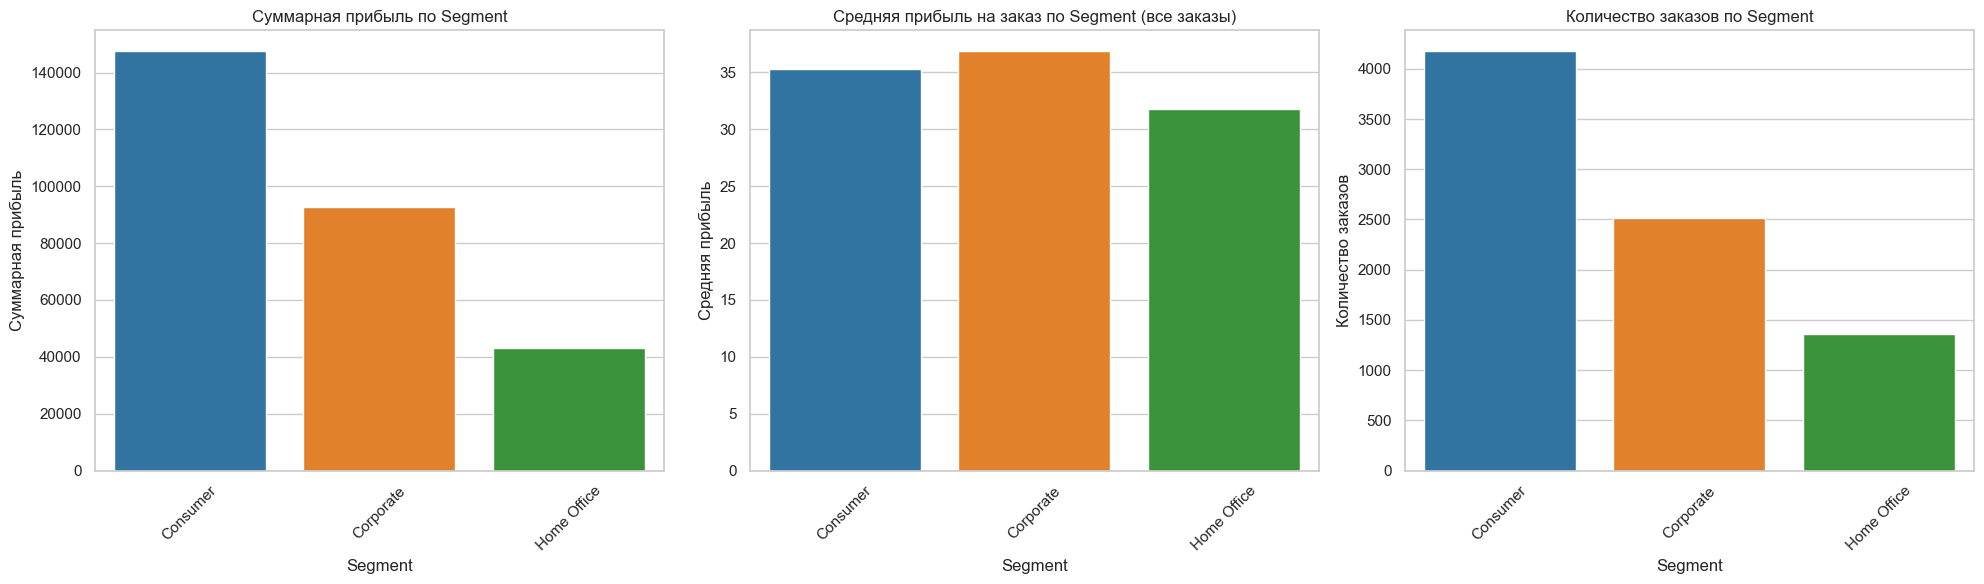


📊 Распределение прибыли по категориям внутри топ-10 Segment


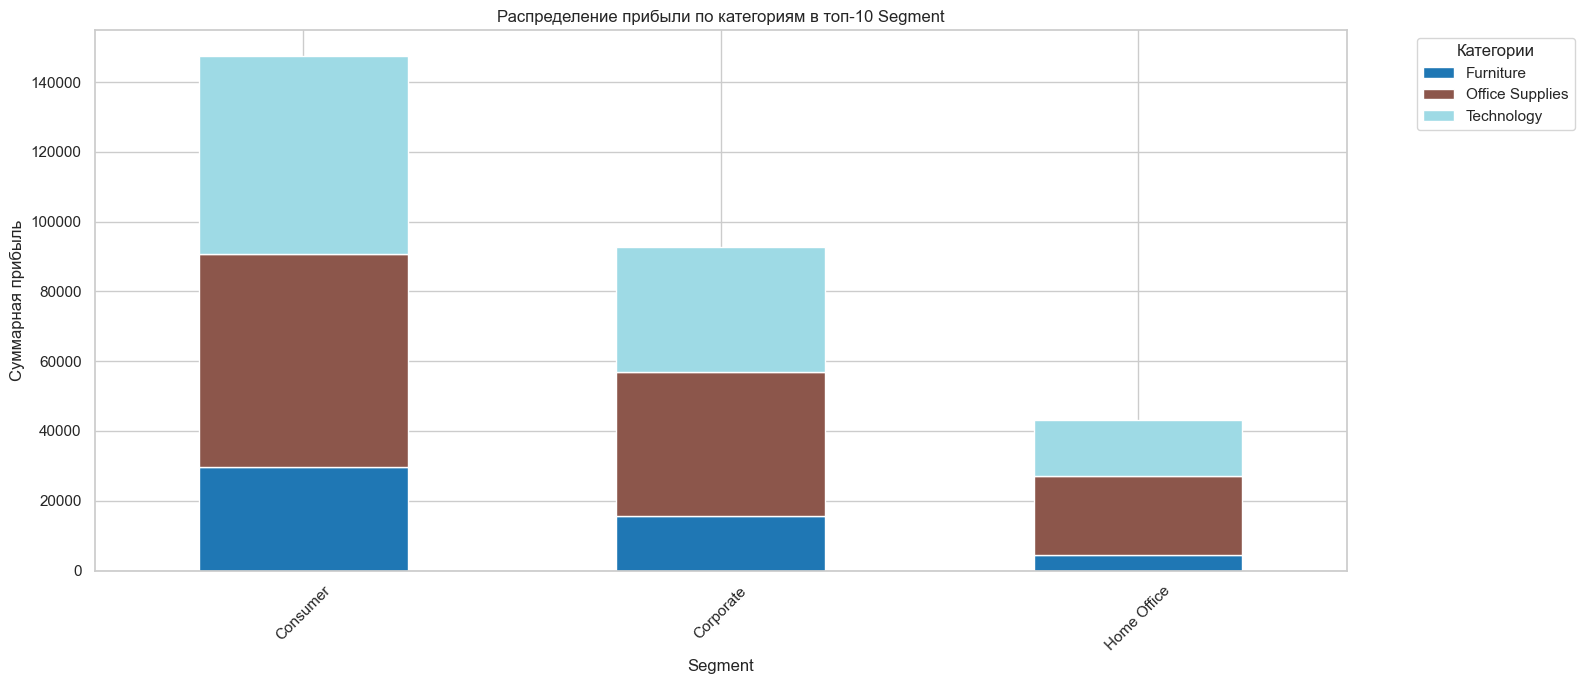


💡 Вывод по 'Segment':
- Максимальная суммарная прибыль у 'Consumer' — 147 447
- Минимальная суммарная прибыль у 'Home Office' — 43 159
- Средняя прибыль на заказ (все заказы) варьируется от 31.76 до 36.85
- Средняя прибыль на заказ (только прибыльные) варьируется от 69.81 до 74.29
- Количество заказов в топ-10 'Segment' варьируется от 1 359 до 4 174
- Процент убыточных заказов в топ-10 'Segment':
  • Consumer: 22.21%
  • Corporate: 20.45%
  • Home Office: 21.56%


In [36]:
analyze_profit_by_category(df, 'Segment')

Сегмент Consumer (частные покупатели) лидирует по прибыли благодаря большему числу мелких заказов и разнообразию ассортимента, но из‑за скидок и возвратов у них выше риск убыточных сделок. Corporate (корпоративные клиенты) стабилен в объёмах и марже, т.к. работает по договорным ценам. Home Office (домашние офисы) генерирует меньше прибыли из‑за низких заказных объёмов и ограниченного ассортимента. Каждый сегмент требует своей ценовой и ассортиментной стратегии.

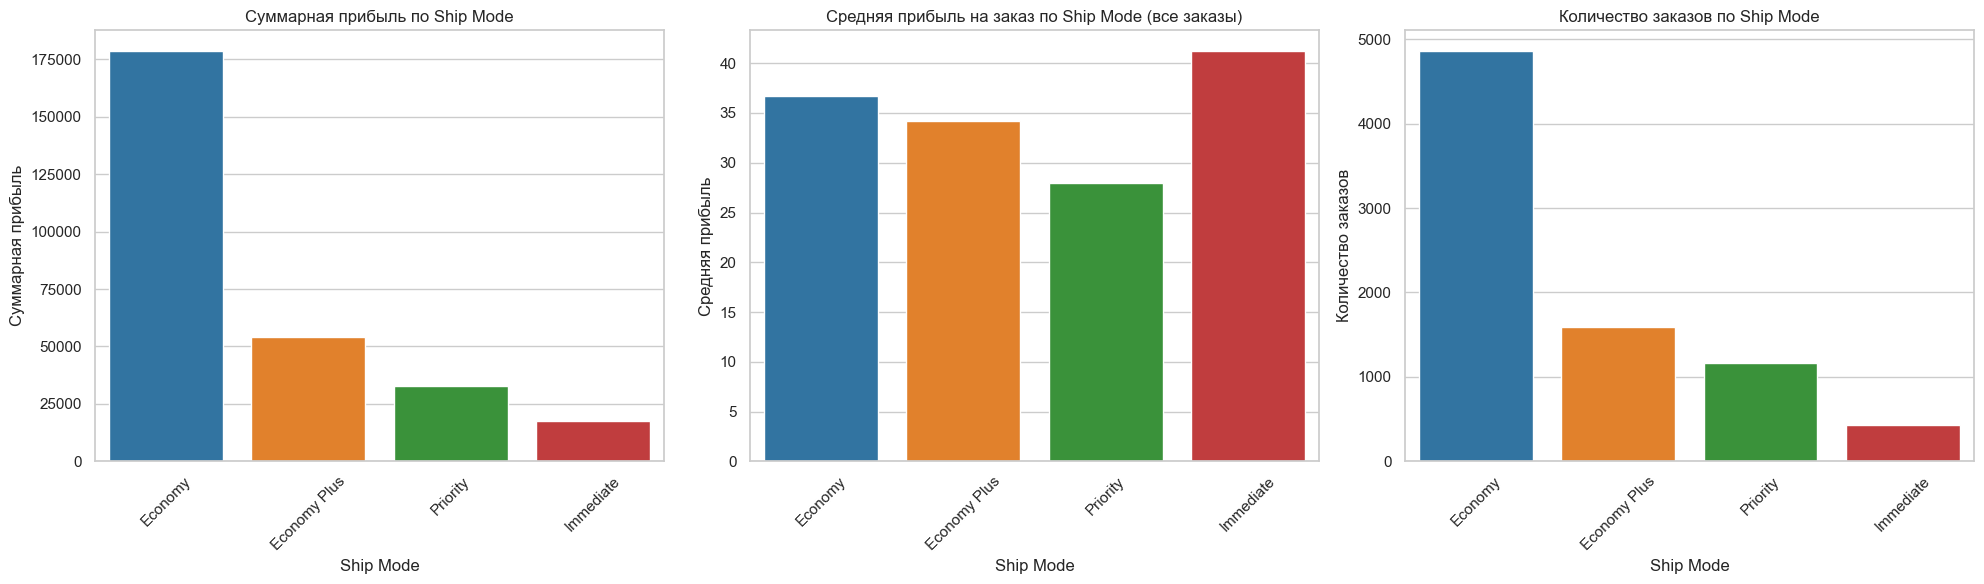


📊 Распределение прибыли по категориям внутри топ-10 Ship Mode


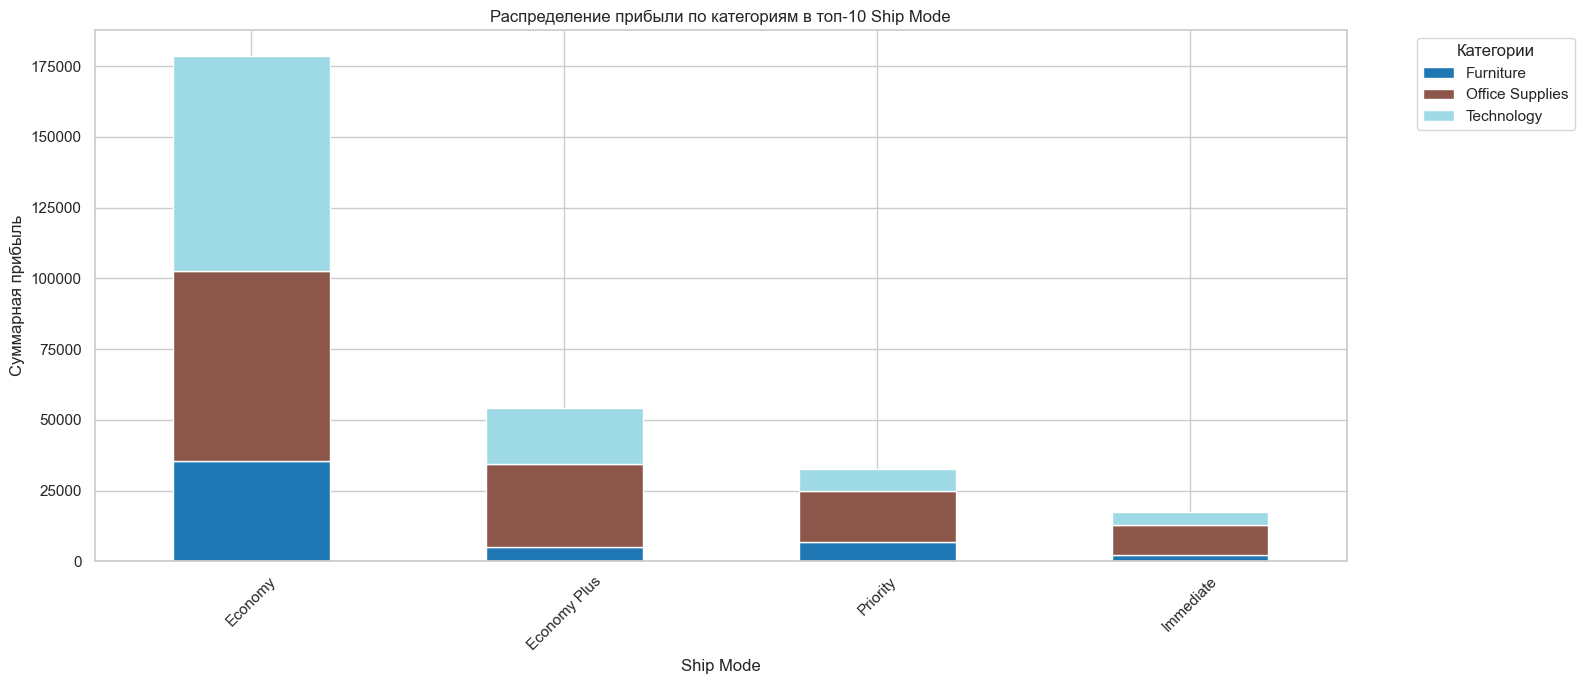


💡 Вывод по 'Ship Mode':
- Максимальная суммарная прибыль у 'Economy' — 178 696
- Минимальная суммарная прибыль у 'Immediate' — 17 569
- Средняя прибыль на заказ (все заказы) варьируется от 27.92 до 41.24
- Средняя прибыль на заказ (только прибыльные) варьируется от 68.36 до 81.70
- Количество заказов в топ-10 'Ship Mode' варьируется от 426 до 4 862
- Процент убыточных заказов в топ-10 'Ship Mode':
  • Economy: 21.74%
  • Economy Plus: 21.19%
  • Priority: 22.33%
  • Immediate: 18.54%


In [37]:
analyze_profit_by_category(df, 'Ship Mode')

Economy справляется с большим количеством дешёвых отправлений в крупных рынках, поэтому её убыточность ~22% — много малых заказов и возвратов. Priority (~22%) и Economy Plus (~21%) скорее всего какая-та премиум услуга платежеспособных регионах, где клиенты готовы переплачивать за скорость доставки.

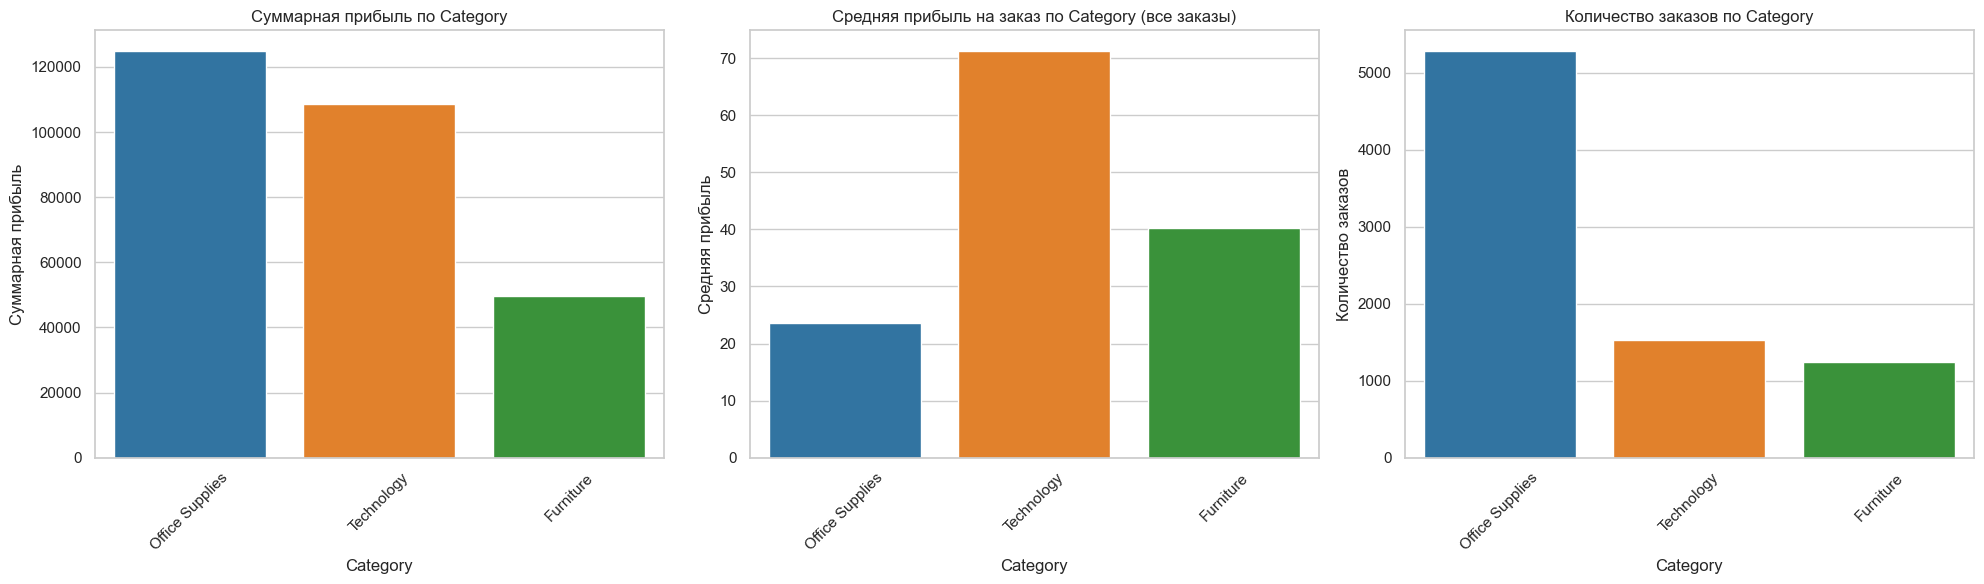


📊 Распределение прибыли по категориям внутри топ-10 Category


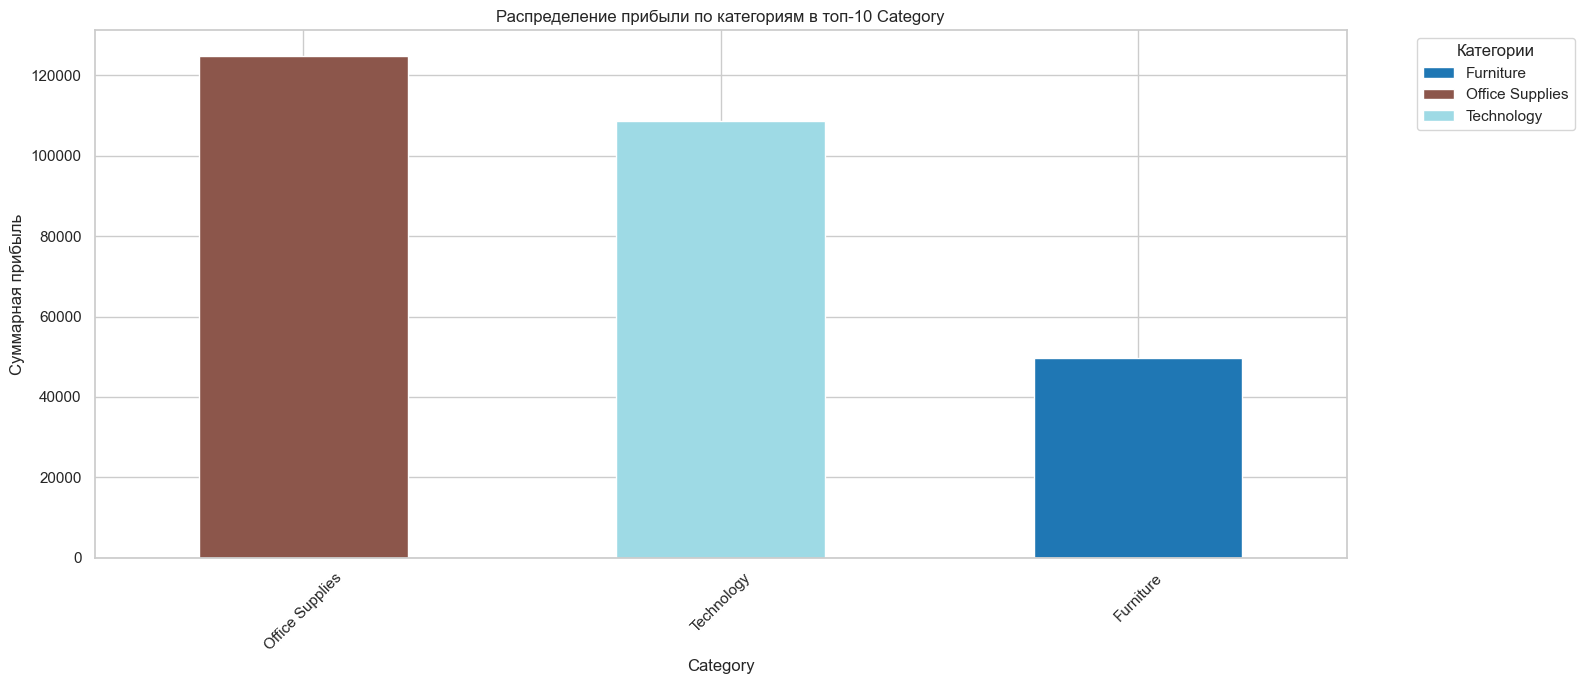


💡 Вывод по 'Category':
- Максимальная суммарная прибыль у 'Office Supplies' — 124 952
- Минимальная суммарная прибыль у 'Furniture' — 49 734
- Средняя прибыль на заказ (все заказы) варьируется от 23.64 до 71.28
- Средняя прибыль на заказ (только прибыльные) варьируется от 40.46 до 151.90
- Количество заказов в топ-10 'Category' варьируется от 1 238 до 5 286
- Процент убыточных заказов в топ-10 'Category':
  • Office Supplies: 18.37%
  • Technology: 26.85%
  • Furniture: 28.59%


In [38]:
analyze_profit_by_category(df, 'Category')

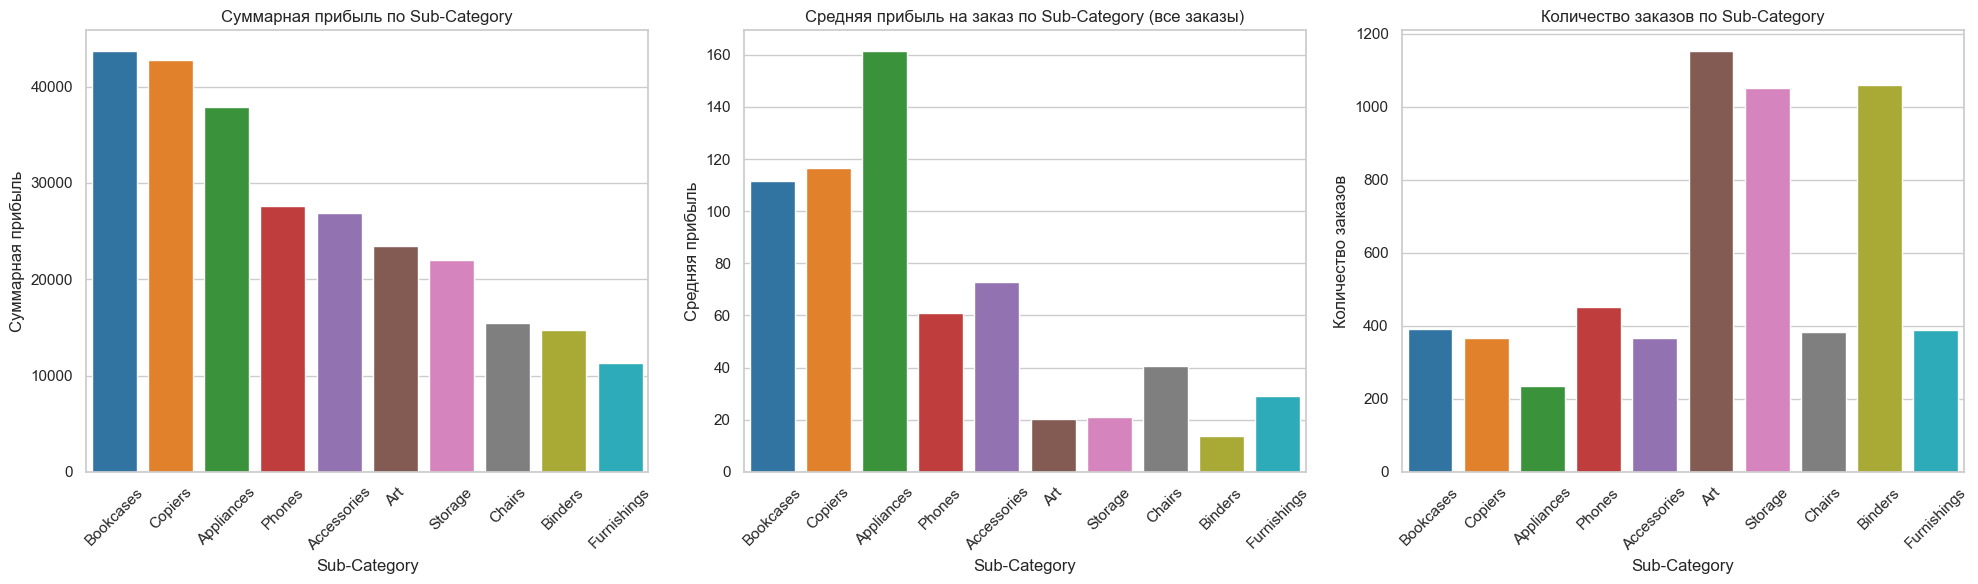


📊 Распределение прибыли по категориям внутри топ-10 Sub-Category


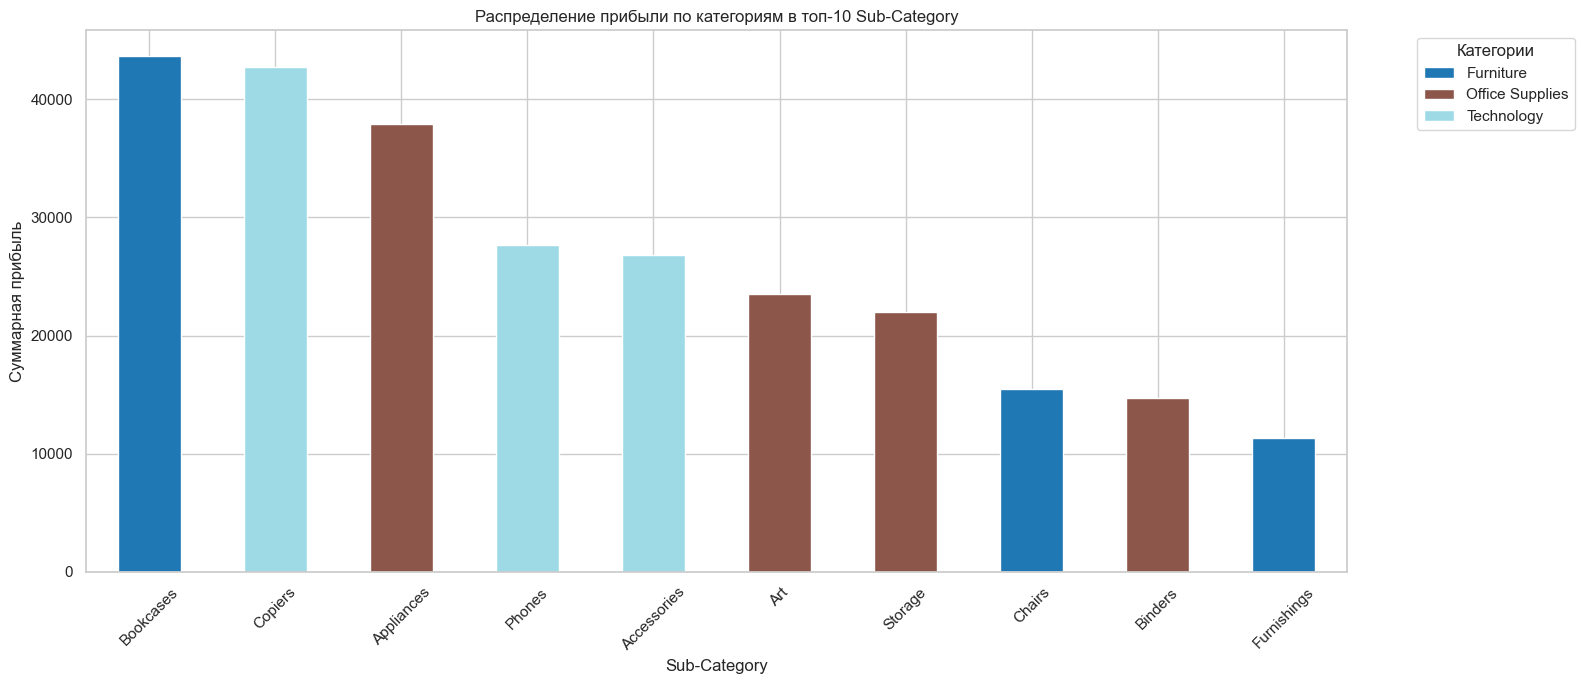


💡 Вывод по 'Sub-Category':
- Максимальная суммарная прибыль у 'Bookcases' — 43 655
- Минимальная суммарная прибыль у 'Furnishings' — 11 321
- Средняя прибыль на заказ (все заказы) варьируется от 13.88 до 161.30
- Средняя прибыль на заказ (только прибыльные) варьируется от 20.47 до 275.54
- Количество заказов в топ-10 'Sub-Category' варьируется от 235 до 1 152
- Процент убыточных заказов в топ-10 'Sub-Category':
  • Bookcases: 20.20%
  • Copiers: 24.25%
  • Appliances: 24.68%
  • Phones: 34.22%
  • Accessories: 12.50%
  • Art: 14.32%
  • Storage: 34.25%
  • Chairs: 37.60%
  • Binders: 12.84%
  • Furnishings: 19.79%


In [39]:
analyze_profit_by_category(df, 'Sub-Category')

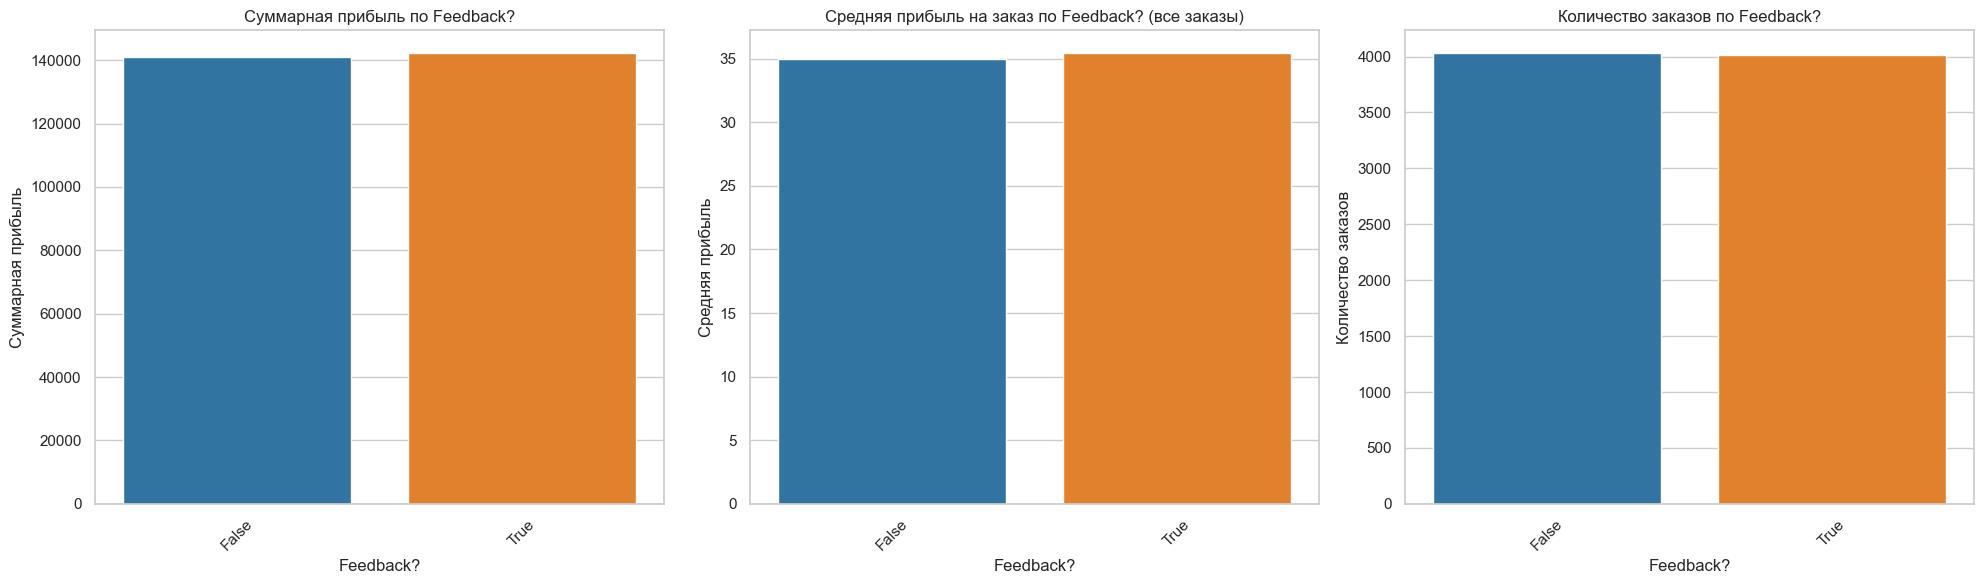


📊 Распределение прибыли по категориям внутри топ-10 Feedback?


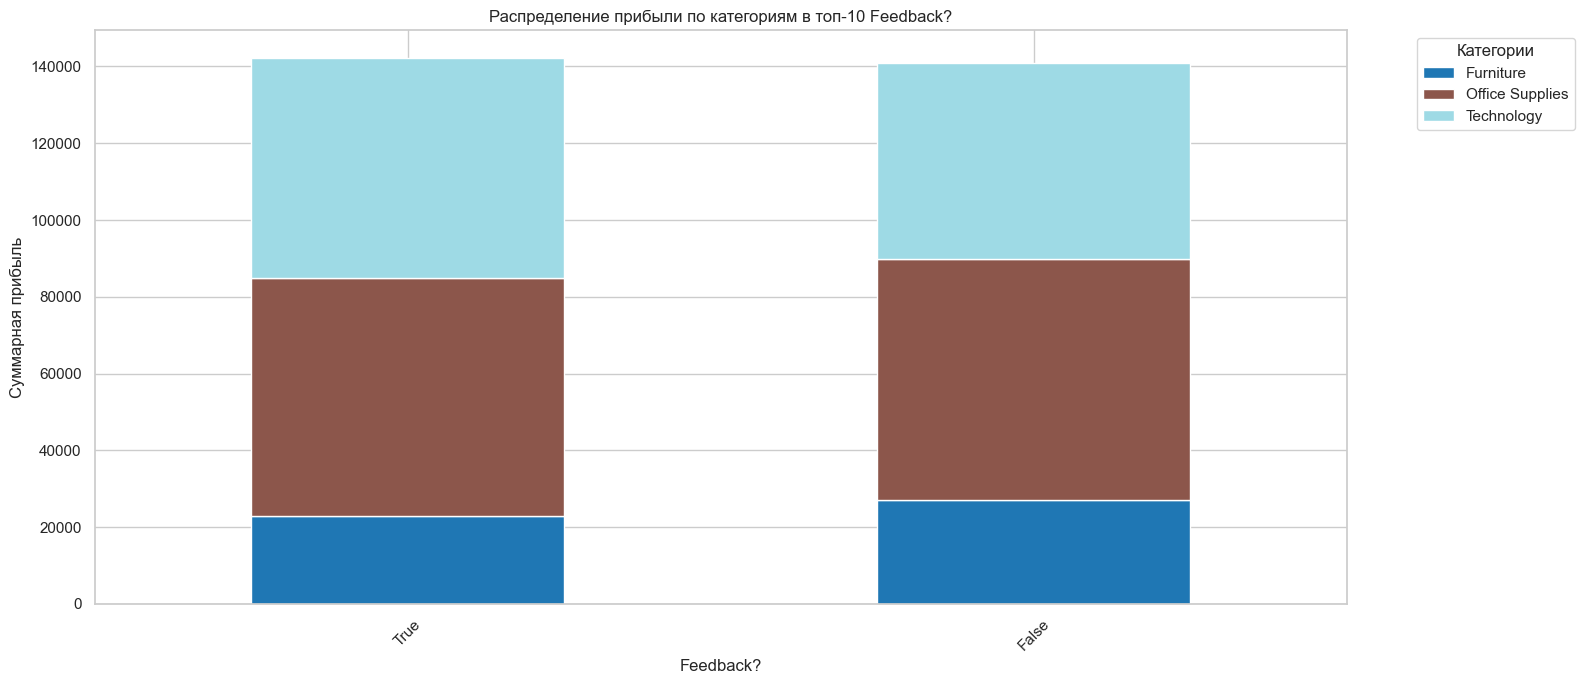


💡 Вывод по 'Feedback?':
- Максимальная суммарная прибыль у 'True' — 142 304
- Минимальная суммарная прибыль у 'False' — 140 936
- Средняя прибыль на заказ (все заказы) варьируется от 34.95 до 35.45
- Средняя прибыль на заказ (только прибыльные) варьируется от 71.89 до 74.21
- Количество заказов в топ-10 'Feedback?' варьируется от 4 014 до 4 033
- Процент убыточных заказов в топ-10 'Feedback?':
  • True: 21.55%
  • False: 21.55%


In [40]:
analyze_profit_by_category(df, 'Feedback?')

In [41]:
print(df['Country'].head(10))
print(df['Country'].dtype)


0            Sweden
1    United Kingdom
2            France
3    United Kingdom
4    United Kingdom
5            France
6            France
7            France
8            France
9            France
Name: Country, dtype: object
object


Чаще люди полагаются на отзывы при заказе товаров, но убыточность одинаково, т.к. неизвестно понравится человеку тот или иной товар.

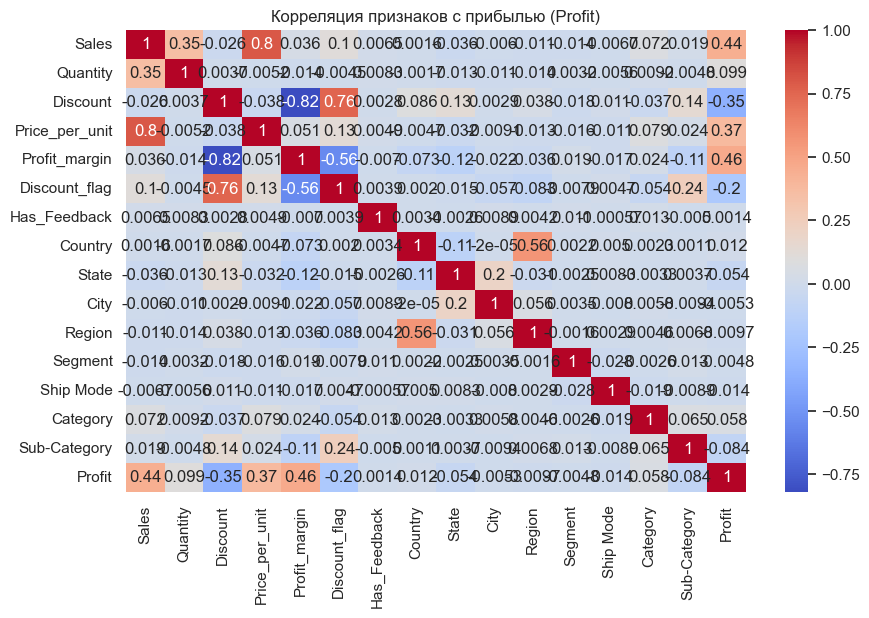


Корреляция с таргетом (Profit):
Profit            1.000000
Profit_margin     0.464795
Sales             0.441217
Price_per_unit    0.374914
Quantity          0.098670
Category          0.058219
Country           0.011599
Has_Feedback      0.001421
Segment          -0.004830
City             -0.005330
Region           -0.009716
Ship Mode        -0.014191
State            -0.053529
Sub-Category     -0.083571
Discount_flag    -0.200810
Discount         -0.351328
Name: Profit, dtype: float64


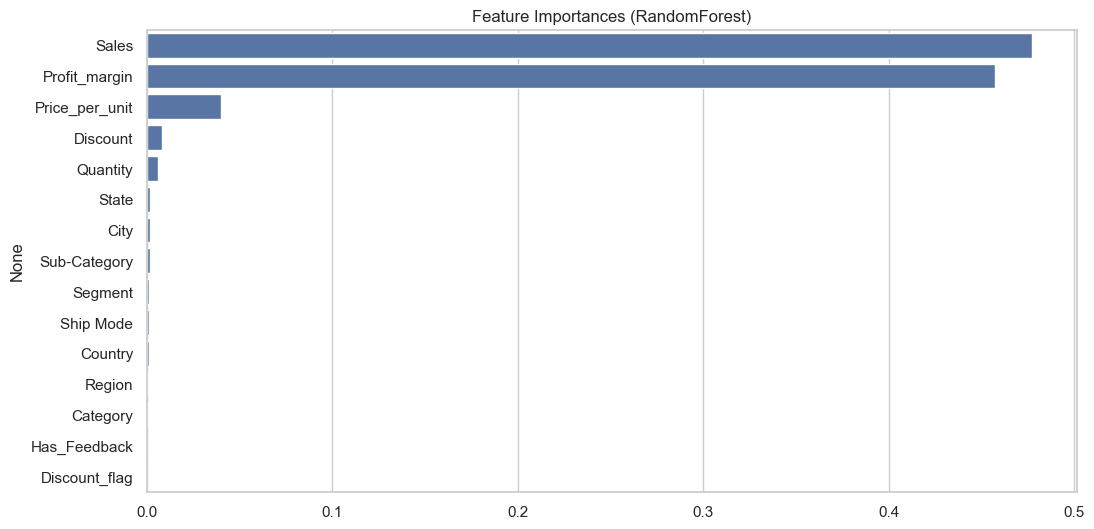

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# --- df уже загружен

# Добавляем новые признаки
df['Price_per_unit'] = df['Sales'] / df['Quantity']
df['Profit_margin'] = df['Profit'] / df['Sales']
df['Discount_flag'] = (df['Discount'] > 0).astype(int)
df['Has_Feedback'] = df['Feedback?'].astype(int)

cat_cols = ['Country', 'State', 'City', 'Region', 'Segment', 'Ship Mode', 'Category', 'Sub-Category']

# Создаем копию df для преобразований
df_encoded = df.copy()

# Кодируем только строковые категориальные признаки в копии
for col in cat_cols:
    if col in df_encoded.columns and df_encoded[col].dtype == 'object':
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Формируем признаки и целевую переменную из копии
feature_cols = ['Sales', 'Quantity', 'Discount', 'Price_per_unit', 'Profit_margin', 'Discount_flag', 'Has_Feedback']
feature_cols += [col for col in cat_cols if col in df_encoded.columns]

X = df_encoded[feature_cols].fillna(0)
y = df_encoded['Profit']

# Далее используем X, y для обучения и анализа, исходный df останется без изменений

# Пример корреляции
plt.figure(figsize=(10,6))
corr = df_encoded[feature_cols + ['Profit']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Корреляция признаков с прибылью (Profit)")
plt.show()

print("\nКорреляция с таргетом (Profit):")
print(corr['Profit'].sort_values(ascending=False))

# Простая модель для оценки важности признаков
rf_simple = RandomForestRegressor(n_estimators=100, random_state=42)
rf_simple.fit(X, y)

importances = rf_simple.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title("Feature Importances (RandomForest)")
plt.show()




In [43]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8047 entries, 0 to 8046
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Order ID        8047 non-null   object        
 1   Order Date      8047 non-null   datetime64[ns]
 2   Customer Name   8047 non-null   object        
 3   Country         8047 non-null   object        
 4   State           8047 non-null   object        
 5   City            8047 non-null   object        
 6   Region          8047 non-null   object        
 7   Segment         8047 non-null   object        
 8   Ship Mode       8047 non-null   object        
 9   Category        8047 non-null   object        
 10  Sub-Category    8047 non-null   object        
 11  Product Name    8047 non-null   object        
 12  Discount        8047 non-null   float64       
 13  Sales           8047 non-null   int64         
 14  Profit          8047 non-null   int64         
 15  Quan

Кросс-валидация моделей:
Linear Regression: R² = 0.3974 ± 0.0585
Random Forest: R² = 0.9627 ± 0.0323
Gradient Boosting: R² = 0.9635 ± 0.0111
XGBoost: R² = 0.9546 ± 0.0338
Neural Network (MLP): R² = 0.5984 ± 0.0954

Лучшая модель: Gradient Boosting с R² = 0.9635


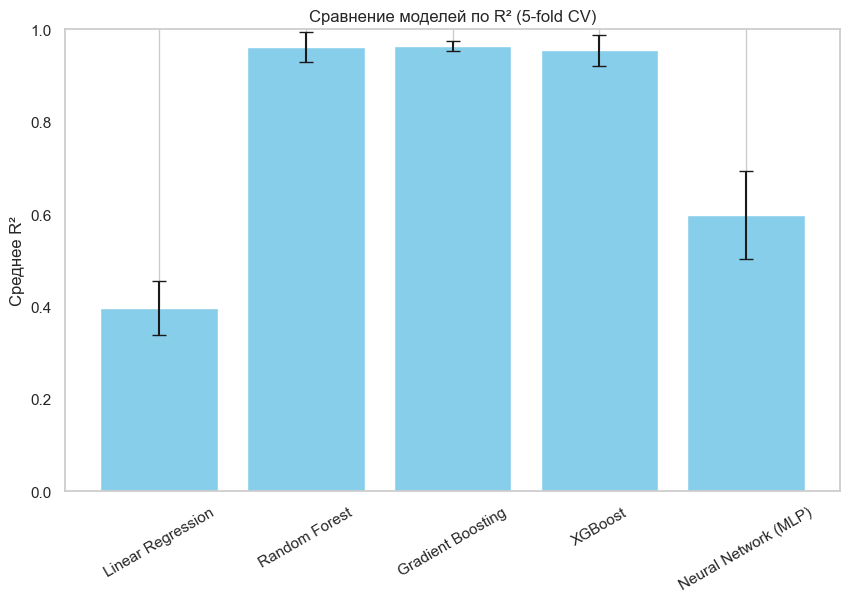


🏅 Наиболее прибыльный регион по суммарной прибыли: Central с прибылью 157636.00


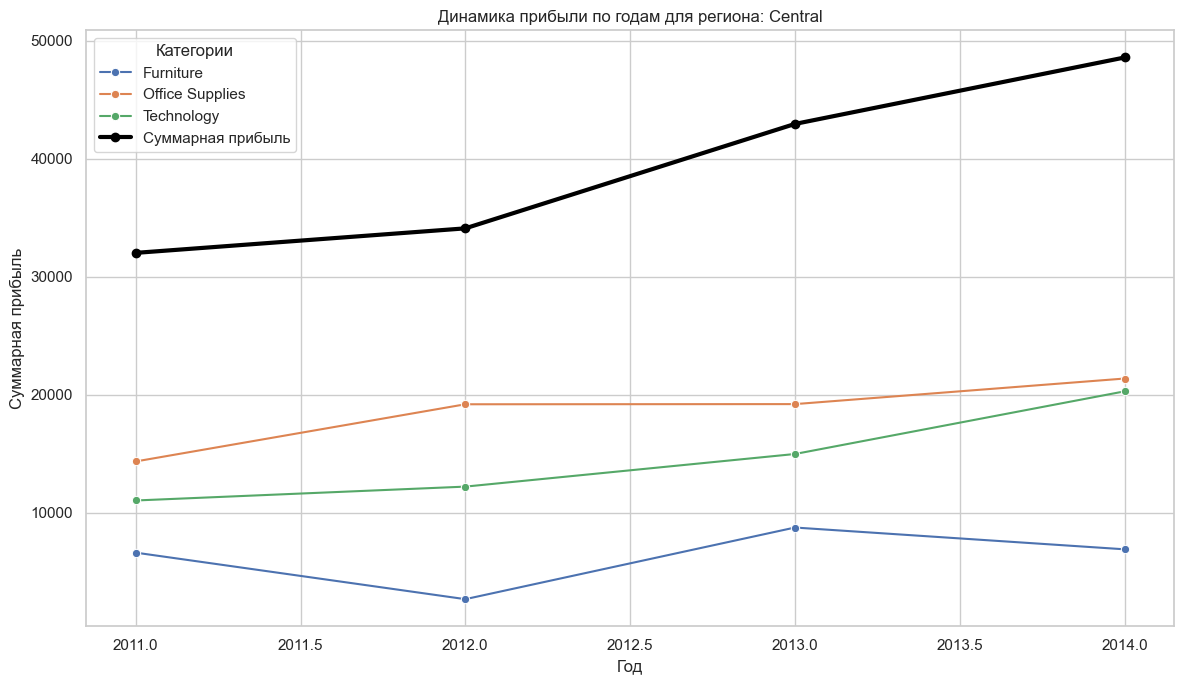

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Предполагается, что df подготовлен и содержит признаки, включая:
# 'Region', 'Year', 'Profit', и что X, y определены (признаки и целевая переменная)

# Заполняем пропуски в признаках (например, нулями)
X_filled = X.fillna(0)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'Neural Network (MLP)': MLPRegressor(hidden_layer_sizes=(64,), activation='relu',
                                         solver='adam', max_iter=500, random_state=42)
}

print("Кросс-валидация моделей:")
for name, model in models.items():
    scores = cross_val_score(model, X_filled, y, cv=cv, scoring='r2')
    cv_results[name] = scores
    print(f"{name}: R² = {scores.mean():.4f} ± {scores.std():.4f}")

best_model_name = max(cv_results, key=lambda k: cv_results[k].mean())
print(f"\nЛучшая модель: {best_model_name} с R² = {cv_results[best_model_name].mean():.4f}")

# Визуализация сравнений моделей
names = list(cv_results.keys())
means = [cv_results[name].mean() for name in names]
stds = [cv_results[name].std() for name in names]

plt.figure(figsize=(10,6))
plt.bar(names, means, yerr=stds, capsize=5, color='skyblue')
plt.ylabel('Среднее R²')
plt.title('Сравнение моделей по R² (5-fold CV)')
plt.ylim(min(0, min(means)-0.1), 1)
plt.grid(axis='y')
plt.xticks(rotation=30)
plt.show()

# --- Анализ наиболее прибыльного региона ---

region_profit = df.groupby('Region')['Profit'].sum().sort_values(ascending=False)

best_region = region_profit.idxmax()
best_region_profit = region_profit.max()

print(f"\n🏅 Наиболее прибыльный регион по суммарной прибыли: {best_region} с прибылью {best_region_profit:.2f}")

# Обработка даты и создание года
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Year'] = df['Order Date'].dt.year

# Фильтруем данные по лучшему региону
df_region = df[df['Region'] == best_region]

# Группируем прибыль по годам и категориям
profit_by_year_cat = df_region.groupby(['Year', 'Category'])['Profit'].sum().reset_index()

# Суммарная прибыль по годам в регионе
profit_by_year_total = df_region.groupby('Year')['Profit'].sum().reset_index()

# Построение графика с плавными линиями
plt.figure(figsize=(12,7))

# Линии прибыли по категориям
sns.lineplot(data=profit_by_year_cat, x='Year', y='Profit', hue='Category', marker='o', ci=None)

# Суммарная линия (черная толстая)
plt.plot(profit_by_year_total['Year'], profit_by_year_total['Profit'],
         color='black', marker='o', linewidth=3, label='Суммарная прибыль')

plt.title(f"Динамика прибыли по годам для региона: {best_region}")
plt.xlabel("Год")
plt.ylabel("Суммарная прибыль")
plt.legend(title='Категории', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



Лучшая модель: Random Forest с R² = 0.5876


In [45]:
import joblib

# Обучаем лучшую модель на всех данных
best_model = models[best_model_name]
best_model.fit(X_filled, y)

# Сохраняем модель в файл
joblib.dump(best_model, 'best_model.pkl')
print(f"Лучшая модель '{best_model_name}' сохранена в файл 'best_model.pkl'")


Лучшая модель 'Gradient Boosting' сохранена в файл 'best_model.pkl'


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8047 entries, 0 to 8046
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Order ID        8047 non-null   object        
 1   Order Date      8047 non-null   datetime64[ns]
 2   Customer Name   8047 non-null   object        
 3   Country         8047 non-null   object        
 4   State           8047 non-null   object        
 5   City            8047 non-null   object        
 6   Region          8047 non-null   object        
 7   Segment         8047 non-null   object        
 8   Ship Mode       8047 non-null   object        
 9   Category        8047 non-null   object        
 10  Sub-Category    8047 non-null   object        
 11  Product Name    8047 non-null   object        
 12  Discount        8047 non-null   float64       
 13  Sales           8047 non-null   int64         
 14  Profit          8047 non-null   int64         
 15  Quan